In [1]:
gimport bayes3d as b
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import matplotlib

In [2]:
b.setup_renderer

<function bayes3d.renderer.setup_renderer(intrinsics, num_layers=1024)>

In [24]:

intrinsics = b.Intrinsics(
    height=310,
    width=300,
    fx=500.0, fy=500.0,
    cx=150.0, cy=155.0,
    near=0.01, far=10.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=3.0/1000.0)

# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (320, 320, 1024)


In [4]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [109]:
b.ycb_loader.MODEL_NAMES[12]

'024_bowl'

In [124]:
IDX = 12
frames = 20
dots = 150
pc = jnp.array(b.RENDERER.meshes[IDX].vertices)
lifetime = 5 #keep 1-1/5 of the dots after every frame update

pc_subsample_start = pc[jax.random.choice(jax.random.PRNGKey(10), jnp.arange(pc.shape[0]), shape=(dots,) )] #want 1000 dots total
pc_replacements = pc[jax.random.choice(jax.random.PRNGKey(0), jnp.arange(pc.shape[0]), shape=(frames,dots//lifetime) )]

pc_subsamples = jnp.zeros((frames,*pc_subsample_start.shape))
pc_subsamples = pc_subsamples.at[0,...].set(pc_subsample_start)
for i in range(1,frames):
    pc_subsamples = pc_subsamples.at[i,...].set(pc_subsamples[i-1,...])
    sampled_indices = jax.random.choice(jax.random.PRNGKey(i), jnp.arange(dots), shape=(dots//lifetime,) )
    pc_subsamples = pc_subsamples.at[i,sampled_indices,...].set(pc_replacements[i,...])

print(pc_subsamples.shape)
    

(20, 150, 3)


In [125]:
b.show_cloud("1", pc_subsamples[0])

In [126]:
poses = jnp.array([b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
)) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle) for angle in jnp.linspace(0.0, 4*jnp.pi, frames)])

print(poses.shape)

(20, 4, 4)


In [127]:
def circles_(flips_xy, radius):
    centers = jnp.array((flips_xy>0).nonzero(size=5000,fill_value=jnp.inf))
    x,y = jnp.meshgrid(jnp.arange(flips_xy.shape[1]),jnp.arange(flips_xy.shape[0]))
    xymesh = jnp.array([y,x])
    distances_to_keypoints = (
        jnp.linalg.norm(xymesh[:, :,:,None] - centers[:,None, None,:],
        axis=0
    ))
    index_of_nearest_keypoint = distances_to_keypoints.argmin(2)
    distance_to_nearest_keypoints = distances_to_keypoints.min(2)
    DISTANCE_THRESHOLD = radius
    valid_match_mask = (distance_to_nearest_keypoints < DISTANCE_THRESHOLD)[...,None]
    return valid_match_mask

def render_point_light(pose, pc_to_render, key):
    pc_in_camera_frame = b.t3d.apply_transform(pc_to_render, pose)
    img = b.render_point_cloud(pc_in_camera_frame, intrinsics)
    rendered_image = point_cloud_img = b.RENDERER.render_single_object(pose,  jnp.int32(IDX))[:,:,:3]
    mask = (rendered_image[:,:,2] < intrinsics.far)
    
    matches = (jnp.abs(img[:,:,2] - rendered_image[:,:,2]) < 0.05)
    
    flips = (jax.random.uniform(key,shape=matches.shape) < 0.005)
    
    final_no_noise = mask * matches + (1.0 - mask) * flips
    
    final_with_noise = circles_(final_no_noise, 2)
    return final_no_noise, final_with_noise

render_point_light_parallel_jit = jax.jit(jax.vmap(render_point_light, in_axes=(0,0, 0)))

In [128]:
key = jax.random.PRNGKey(100)
keys = jax.random.split(jax.random.PRNGKey(100), poses.shape[0])
images_no_noise, images = render_point_light_parallel_jit(poses, pc_subsamples, keys)

In [129]:
viz = [b.get_depth_image(1.0 - point_light_image * 1.0, cmap=matplotlib.colormaps['Greys']) for point_light_image in images ]
b.make_gif_from_pil_images(viz, "out_merge.gif")

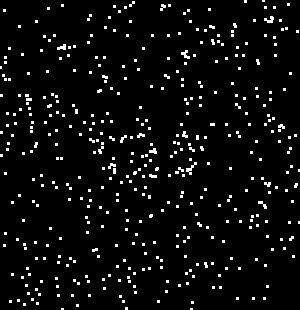

In [130]:
viz[0]